# 0: Curifactory Basic Components

This notebook introduces the four basic components of curifactory and shows how to use them from a live context. (A live context is either a notebook, REPL, or non-experiment script)

The components are:
* the artifact manager
* parameters
* records
* stages

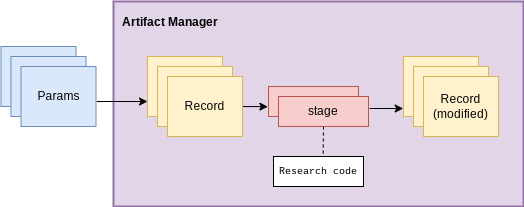
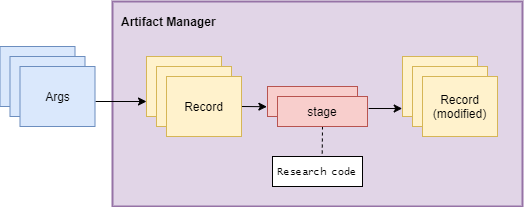

In [1]:
# note that curifactory assumes that the active directory is the project root
%cd ..

/home/81n/lab/curifactory/examples


## Artifact Manager

First up is the **artifact manager**. `ArtifactManager` is a class representing a session that tracks metadata and generated objects from experiment code.

When an artifact manager is instantiated, it creates a new "experiment run", which will have an associated log file and can generate a run-specific report.

In [2]:
from curifactory import ArtifactManager

manager = ArtifactManager("notebook_example_0") # we pass in a name to associate with this run.

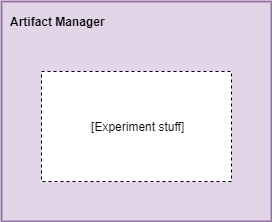  
_The artifact manager contains and keeps track of the overall session for the experiment stuff._

## Parameters

The next component is **parameters**. Parameter classes are a way to define how research code can be parameterized, e.g. how many layers to include in a neural network. By defining and initializing these directly in python, we have the ability to dynamically create experiment parameter configurations, compose them, etc.

Curifactory comes with an `ExperimentParameters` base class that all custom parameter classes should inherit from. `ExperimentParameters` includes a `name` parameter, allowing you to provide a label for the parameter sets.

For best ergonomics, we recommend defining a parameter class with the python `@dataclass` decorator. This makes it easy to define defaults and quickly view your parameter definitions simply as a collection of attributes.

Parameter sets can then be initialized, passed around, and used within your research code, making it easy to organize and keep track of hyperparameters.

In [3]:
from dataclasses import dataclass
from curifactory import ExperimentParameters

@dataclass
class MyParams(ExperimentParameters):
    some_scalar_multiplier: float = 1.0
        
# define a couple argument sets
default_params = MyParams(name="default")
doubled_params = MyParams(name="doubled", some_scalar_multiplier=2.0)

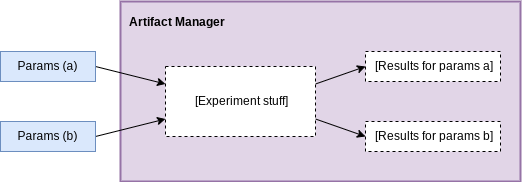  
_Creating and passing different parameter sets through the experiment stuff will give us different sets of results in the manager we can compare._
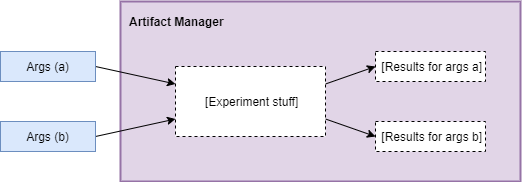

## Records

A **record** is how curifactory keeps track of state in an experiment run. "State" includes the data, objects, and results associated with a specific parameter set, e.g. a trained model that came from using a particular `MyParams` instance. The `Record` class is initialized with the current manager as well as the parameter set to associate with. Records have a `state` dictionary, which holds intermediate data and objects as research code is evaluated.

In [4]:
from curifactory import Record

r0 = Record(manager, default_params)
r1 = Record(manager, doubled_params)

print(r0.state, r0.params)
print(r1.state, r1.params)

{} MyParams(name='default', hash='fbfbde1db878403f89d2b0b9cdf4fbbd', overwrite=False, some_scalar_multiplier=1.0)
{} MyParams(name='doubled', hash='ab202296761d2052e9b6b0376b46785b', overwrite=False, some_scalar_multiplier=2.0)


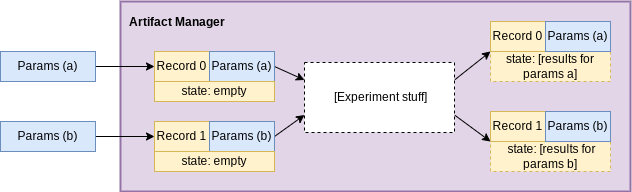  
_The state for each record is what’s actually storing the results from the experiment stuff for each given parameter set._
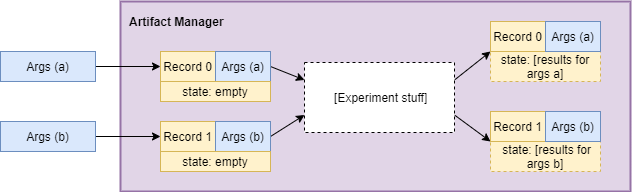

## Stages

A **stage** represents a small, well-defined abstraction around portions of research code which process some set of inputs and create a set of outputs. A stage acts on a given  record by taking the requested inputs from that record's state, evaluates some code, and returning values that are then stored in the record's state. This is implemented with a `@stage` decorator which takes an array of string input names and an array of string output names. Functions with the `@stage` decorator must accept a record as the first argument. 

Inside the stage, the record object that is passed in can be used to get the current parameter set and parameterize the computation, via the `record.params` attribute.

In the example below, we've defined a very simple stage that will store a number in the record's state under the "initial_value" key.

Running a stage works by calling the function and passing it the record. The record itself is changed in-place, but it is also directly returned from the stage call. This allows functionally chaining stages, as will be shown later.

In [5]:
from curifactory import stage

@stage(inputs=None, outputs=["initial_value"])
def get_initial_value(record):
    my_value = 5
    return my_value * record.params.some_scalar_multiplier

r0 = get_initial_value(r0)
r1 = get_initial_value(r1)

14:05:02 INFO     [default] -----                                                                    ]8;id=140741;file:///home/81n/lab/curifactory/curifactory/staging.py\staging.py]8;;\:]8;id=7402;file:///home/81n/lab/curifactory/curifactory/staging.py#157\157]8;;\

         INFO     [default] Stage get_initial_value                                                  ]8;id=334766;file:///home/81n/lab/curifactory/curifactory/staging.py\staging.py]8;;\:]8;id=914858;file:///home/81n/lab/curifactory/curifactory/staging.py#158\158]8;;\

         INFO     [default] Stage get_initial_value executing...                                     ]8;id=558488;file:///home/81n/lab/curifactory/curifactory/staging.py\staging.py]8;;\:]8;id=534199;file:///home/81n/lab/curifactory/curifactory/staging.py#408\408]8;;\

         INFO     [default] Stage get_initial_value complete                                         ]8;id=710438;file:///home/81n/lab/curifactory/curifactory/staging.py\staging.py]8;;\:]8;id=370425;file:///home/81n/lab/curifactory/curifactory/staging.py#460\460]8;;\

         INFO     [doubled] -----                                                                    ]8;id=83486;file:///home/81n/lab/curifactory/curifactory/staging.py\staging.py]8;;\:]8;id=997127;file:///home/81n/lab/curifactory/curifactory/staging.py#157\157]8;;\

         INFO     [doubled] Stage get_initial_value                                                  ]8;id=314207;file:///home/81n/lab/curifactory/curifactory/staging.py\staging.py]8;;\:]8;id=873993;file:///home/81n/lab/curifactory/curifactory/staging.py#158\158]8;;\

         INFO     [doubled] Stage get_initial_value executing...                                     ]8;id=337883;file:///home/81n/lab/curifactory/curifactory/staging.py\staging.py]8;;\:]8;id=646512;file:///home/81n/lab/curifactory/curifactory/staging.py#408\408]8;;\

         INFO     [doubled] Stage get_initial_value complete                                         ]8;id=770347;file:///home/81n/lab/curifactory/curifactory/staging.py\staging.py]8;;\:]8;id=331987;file:///home/81n/lab/curifactory/curifactory/staging.py#460\460]8;;\

After running both records through our stage, printing the states shows the returned `initial_value` data.

In [6]:
print(r0.state, r1.state)

{'initial_value': 5.0} {'initial_value': 10.0}


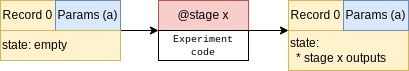  
_Stages are the “experiment stuff”. A stage uses and modifies the state of a passed record. This is where the experiment code actually runs, taking any necessary inputs from the passed record state and storing any returned outputs back into it._
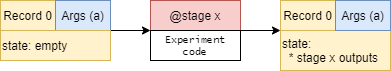

Specifying inputs on the stage decorator tells curifactory to search for those keys in the state of the passed record. Those values are then injected into the record call as kwargs. Note that the argument names in the function definition must match the string values of the inputs array.

`"initial_value"` was added to the state from the `get_initial_value` stage, so we implement a stage below that expects that piece of data and computes a new value based on it.

In [7]:
@stage(inputs=["initial_value"], outputs=["final_value"])
def multiply_again(record, initial_value):
    return initial_value * record.params.some_scalar_multiplier

r1 = multiply_again(r1)
print(r1.state)

         INFO     [doubled] -----                                                                    ]8;id=623018;file:///home/81n/lab/curifactory/curifactory/staging.py\staging.py]8;;\:]8;id=353087;file:///home/81n/lab/curifactory/curifactory/staging.py#157\157]8;;\

         INFO     [doubled] Stage multiply_again                                                     ]8;id=568728;file:///home/81n/lab/curifactory/curifactory/staging.py\staging.py]8;;\:]8;id=181152;file:///home/81n/lab/curifactory/curifactory/staging.py#158\158]8;;\

         INFO     [doubled] Stage multiply_again executing...                                        ]8;id=833705;file:///home/81n/lab/curifactory/curifactory/staging.py\staging.py]8;;\:]8;id=860273;file:///home/81n/lab/curifactory/curifactory/staging.py#408\408]8;;\

         INFO     [doubled] Stage multiply_again complete                                            ]8;id=853779;file:///home/81n/lab/curifactory/curifactory/staging.py\staging.py]8;;\:]8;id=216024;file:///home/81n/lab/curifactory/curifactory/staging.py#460\460]8;;\

{'initial_value': 10.0, 'final_value': 20.0}


As mentioned before, since a stage accepts and returns a record, stages can be functionally chained together:

In [8]:
r2 = Record(manager, MyParams(name="uber-double", some_scalar_multiplier=4.0))

r2 = multiply_again(get_initial_value(r2))
print(r2.state, r2.params)

         INFO     [uber-double] -----                                                                ]8;id=948223;file:///home/81n/lab/curifactory/curifactory/staging.py\staging.py]8;;\:]8;id=476556;file:///home/81n/lab/curifactory/curifactory/staging.py#157\157]8;;\

         INFO     [uber-double] Stage get_initial_value                                              ]8;id=770790;file:///home/81n/lab/curifactory/curifactory/staging.py\staging.py]8;;\:]8;id=853638;file:///home/81n/lab/curifactory/curifactory/staging.py#158\158]8;;\

         INFO     [uber-double] Stage get_initial_value executing...                                 ]8;id=505586;file:///home/81n/lab/curifactory/curifactory/staging.py\staging.py]8;;\:]8;id=68949;file:///home/81n/lab/curifactory/curifactory/staging.py#408\408]8;;\

         INFO     [uber-double] Stage get_initial_value complete                                     ]8;id=884476;file:///home/81n/lab/curifactory/curifactory/staging.py\staging.py]8;;\:]8;id=984067;file:///home/81n/lab/curifactory/curifactory/staging.py#460\460]8;;\

         INFO     [uber-double] -----                                                                ]8;id=54132;file:///home/81n/lab/curifactory/curifactory/staging.py\staging.py]8;;\:]8;id=635775;file:///home/81n/lab/curifactory/curifactory/staging.py#157\157]8;;\

         INFO     [uber-double] Stage multiply_again                                                 ]8;id=342056;file:///home/81n/lab/curifactory/curifactory/staging.py\staging.py]8;;\:]8;id=760049;file:///home/81n/lab/curifactory/curifactory/staging.py#158\158]8;;\

         INFO     [uber-double] Stage multiply_again executing...                                    ]8;id=327620;file:///home/81n/lab/curifactory/curifactory/staging.py\staging.py]8;;\:]8;id=132132;file:///home/81n/lab/curifactory/curifactory/staging.py#408\408]8;;\

         INFO     [uber-double] Stage multiply_again complete                                        ]8;id=725166;file:///home/81n/lab/curifactory/curifactory/staging.py\staging.py]8;;\:]8;id=541957;file:///home/81n/lab/curifactory/curifactory/staging.py#460\460]8;;\

{'initial_value': 20.0, 'final_value': 80.0} MyParams(name='uber-double', hash='a4337711dc83557f076bccd2b015e2ad', overwrite=False, some_scalar_multiplier=4.0)


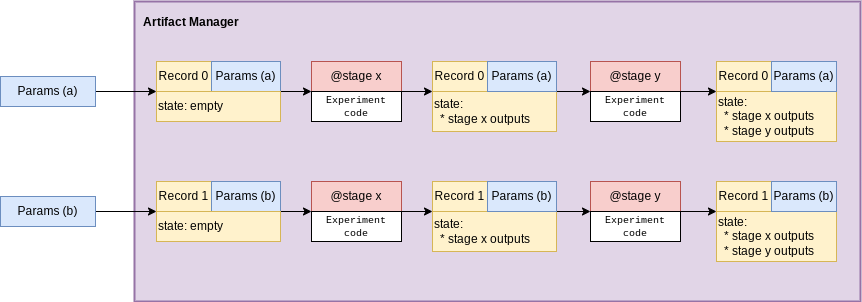  
_Records can be “pipelined” through sequences of stages to create a full experiment composed of larger abstract steps._
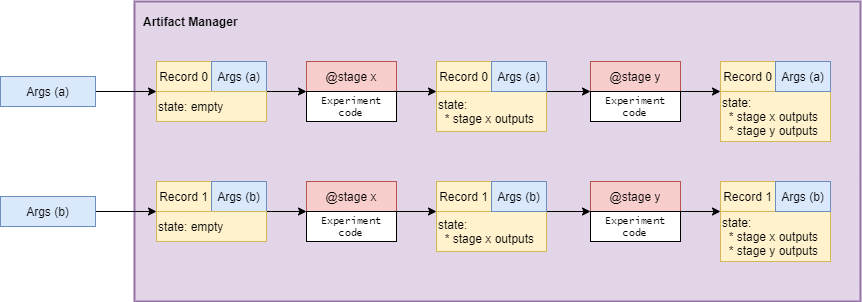

Records and stages represent linear tracks of compute steps, but in many cases it's important to compare across multiple pieces of an experiment run (e.g. comparing the scores of an SVM with the scores of a logistic regression algorithm.) ``@aggregate`` decorated functions are a special kind of stage that additionally take a collection of records to compute over. Aggregate stages still produce outputs and both take and return a single record associated with it, meaning additional regular stages can be chained after an aggregate stage.

We specify inputs to an `@aggregate` decorator the same way we do with `@stage`, with a list of string names of artifacts from record state, and the function definition still needs to have correspondingly named arguments for those inputs. However, since an aggregate takes multiple records, these input arguments are populated with dictionaries where each key is a record that has the requested input in its state, and the value is that object in the state. Any records that don't have the requested input will throw a warning, and will be absent from that dictionary.

`@aggregate` decorated stages must take the single record as the first parameter (like a normal stage,) and the collection of records to compute over as the second, followed by the arguments for any specified inputs.

In the example below, we iterate through the records to create a dictionary of all associated `final_value` entries from each record's state, and then determine the maximum.

In [9]:
from curifactory import aggregate

@aggregate(inputs=["final_value"], outputs=["all_final_values", "maximum_value"])
def find_maximum_final_value(record, records, final_value: dict[Record, float]):
    all_vals = {}
    for r, value in final_value.items():
        all_vals[r.params.name] = value
        
    maximum = max(all_vals.values())
    return all_vals, maximum


Sometimes an aggregate doesn't really need its own parameter set, e.g. if it's
simply comparing results from other records. In these cases, records can be initialized with `None` passed as the
parameter set. In the cell below, we manually pass our previous records into
the stage, but note that if we pass `None` for records (the default) it will take all existing records in the manager.


In [10]:
final_record = Record(manager, None)
final_record = find_maximum_final_value(final_record, [r0, r1, r2])
print(final_record.state)

         INFO     -----                                                                              ]8;id=827720;file:///home/81n/lab/curifactory/curifactory/staging.py\staging.py]8;;\:]8;id=715458;file:///home/81n/lab/curifactory/curifactory/staging.py#564\564]8;;\

         INFO     Stage (aggregate) find_maximum_final_value                                         ]8;id=683402;file:///home/81n/lab/curifactory/curifactory/staging.py\staging.py]8;;\:]8;id=56360;file:///home/81n/lab/curifactory/curifactory/staging.py#565\565]8;;\

         WARNING  Artifact 'final_value' not found in Record 0 (default)                             ]8;id=143936;file:///home/81n/lab/curifactory/curifactory/staging.py\staging.py]8;;\:]8;id=497413;file:///home/81n/lab/curifactory/curifactory/staging.py#659\659]8;;\

         INFO     Stage (aggregate) find_maximum_final_value executing...                            ]8;id=31993;file:///home/81n/lab/curifactory/curifactory/staging.py\staging.py]8;;\:]8;id=828595;file:///home/81n/lab/curifactory/curifactory/staging.py#817\817]8;;\

         INFO     Stage (aggregate) find_maximum_final_value complete                                ]8;id=982616;file:///home/81n/lab/curifactory/curifactory/staging.py\staging.py]8;;\:]8;id=513555;file:///home/81n/lab/curifactory/curifactory/staging.py#865\865]8;;\

{'all_final_values': {'doubled': 20.0, 'uber-double': 80.0}, 'maximum_value': 80.0}


Note that we ran our aggregate stage on three records, the first one of which (`r0`) did not have a `final_value` artifact in state. While `r0` will still be passed in the `records` list that the aggregate stage has access to, the `final_value` dictionary only had entries for `r1` and `r2`, so the output artifact `all_final_values` only lists those two parameter sets.

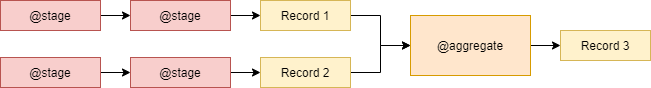

To recap, the artifact manager keeps track of the overall session for a
run, the “experiment run container”. Parameter sets are created with
different hyperparameters to test a hypothesis or vary the experiment.
Records track state changes and intermediate data associated with a
parameter set throughout the experiment. Stages are what modify record state,
they apply research code
to the passed records based on their associated parameters, and the
results for each stage are stored back into the record’s now modified
state.

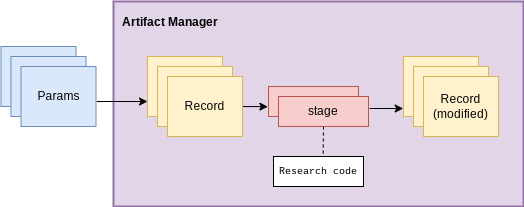
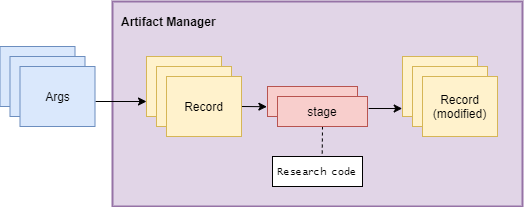